In [1]:
# Dependencies
from sklearn.metrics import precision_score, recall_score, f1_score
from src.dataset import FashionDataset, DataLoader, ToTensor, Resize
from src.model import MultiLabelClassifier, train, test, save
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn as nn
import torch
import os

# Define random seed
np.random.seed(42)
# Make matplotlib inline
%matplotlib inline

In [2]:
# Define path to data directory
data_dir = './data'
# Define path to images directory
images_dir = os.path.join(data_dir, 'images')
# Define path to tokens/labels
tokens_path = os.path.join(data_dir, 'tokens.json')
# Define path to vocabulary
vocabulary_path = os.path.join(data_dir, 'vocabulary.json')

In [3]:
# Define transformation
transform = transforms.Compose([ToTensor(), Resize(size=(80, 60))])
transform

Compose(
)

In [4]:
# Define dataset
ds = FashionDataset(images_dir, tokens_path, vocabulary_path, transform=transform)
# Retrieve word to index mapping
w2i = ds.vocabulary
# Define index to word mapping
i2w = {i: w for w, i in w2i.items()}
# Show a few lines in dataset
print({i2w[i]: i for i in range(0, 10)})

{'peace': 0, 'lilac': 1, 'zoe': 2, 'ellis': 3, 'chino': 4, 'jewel': 5, 'handle': 6, 'magenta': 7, 'hahk': 8, 'folklore': 9}


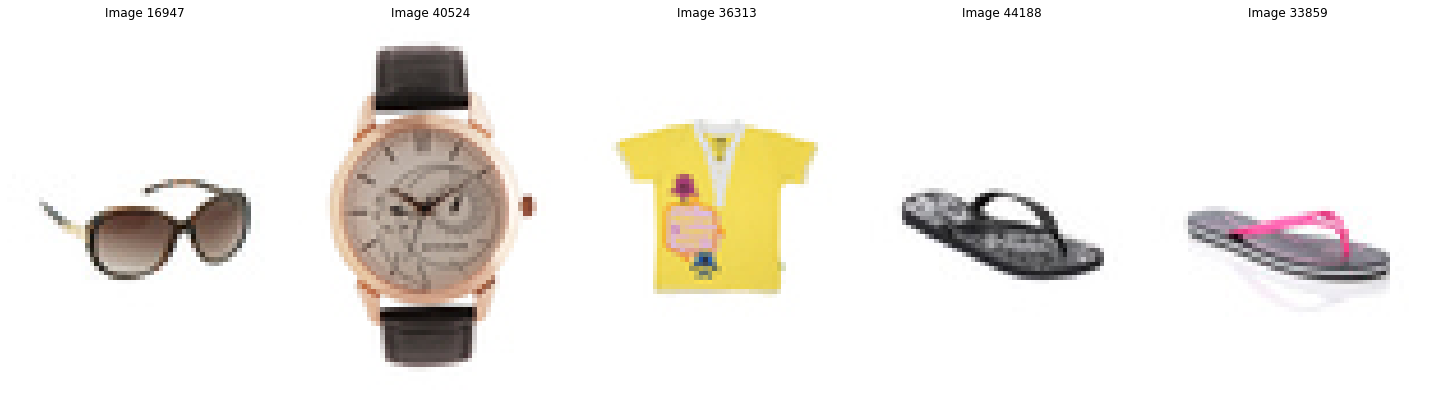

In [5]:
# Define number of samples
n = 5
#  Initialize plot
fig, axs = plt.subplots(1, n, figsize=(20, 20))
# Loop through some random images
for i, j in enumerate(np.random.choice(np.arange(0, len(ds)), size=n, replace=False)):
    # Get i-th sample in dataset
    sample = ds[j]
    # Get image from sample
    image = sample['image']
    # Plot image
    axs[i].imshow(image.numpy().transpose((1, 2, 0)))
    # Get image title
    title = 'Image %s' % ds.index[j]
    # Add title
    axs[i].set_title(title)
    # Remove axis
    axs[i].set_axis_off()
# Set tight layout
_ = plt.tight_layout()
# Show plot
_ = plt.show()

In [6]:
# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
# Get pre-trained model from PyTorch hub
model = MultiLabelClassifier(out_features=len(ds.vocabulary), verbose=True)
model.to(device)

Using cache found in /home/damiclem/.cache/torch/hub/pytorch_vision_v0.10.0


MultiLabelClassifier(
  (out): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1,

In [8]:
# Define size of train and test dataset
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
# Split initial dataset
ds_train, ds_test = torch.utils.data.random_split(ds, [train_size, test_size])
# Show size of train and test dataset
len(ds_train), len(ds_test)

(35535, 8884)

In [9]:
# Define batch size
batch_size=100
# Define train and test data loader
dl_train = DataLoader(ds_train, shuffle=True, batch_size=batch_size)
dl_test = DataLoader(ds_test, shuffle=False, batch_size=batch_size)
dl_train, dl_test

(<torch.utils.data.dataloader.DataLoader at 0x7f47fd6f2d30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f47fd6f2d90>)

In [10]:
# Define learning rate
learning_rate = 1e-3
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [11]:
# Define loss function
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

In [12]:
# Define evaluation function
def eval_fn(predicted, target):
    # Predict as true values above 0.5
    predicted = predicted > 0.5
    # Compare true vs. false values
    return {
        'micro/precision': precision_score(y_true=target, y_pred=predicted, average='micro'),
        'micro/recall': recall_score(y_true=target, y_pred=predicted, average='micro'),
        'micro/f1': f1_score(y_true=target, y_pred=predicted, average='micro'),
        'macro/precision': precision_score(y_true=target, y_pred=predicted, average='macro'),
        'macro/recall': recall_score(y_true=target, y_pred=predicted, average='macro'),
        'macro/f1': f1_score(y_true=target, y_pred=predicted, average='macro'),
        'samples/precision': precision_score(y_true=target, y_pred=predicted, average='samples'),
        'samples/recall': recall_score(y_true=target, y_pred=predicted, average='samples'),
        'samples/f1': f1_score(y_true=target, y_pred=predicted, average='samples'),
    }

In [13]:
# Define number of epochs
num_epochs = 100
# Initialize number of iterations
num_iterations = 0
# Define directory for current model
model_dir = os.path.join('data', 'models', '%d' % int(datetime.now().timestamp()))
# Eventually, make new directory
os.makedirs(model_dir, exist_ok=True)
# Define train and test losses
train_loss, test_loss = [], []
# Define test evaluation scores
test_eval = []
# Loop through given number of epochs
for epoch in tqdm(range(0, num_epochs)):
    # Train model, store losses
    for loss in train(model, data=dl_train, optimizer=optimizer, loss_fn=loss_fn):
        # Store loss
        train_loss.append(loss)
        # Update number of iterations
        num_iterations += 1
    # Test model, store losses
    for loss, eval in test(model, data=dl_test, loss_fn=loss_fn, eval_fn=eval_fn):
        # Store loss
        test_loss.append(loss)
        # Store evaluation
        test_eval.append(eval)
    # Save model to disk
    save(model, path=os.path.join(model_dir, 'params-%d.pt' % epoch))
    # Stop earlier if average loss over last 5 epochs was lower
    if (epoch > 5) and (test_loss[-1] > np.mean(test_loss[-5:-1])):
        # Just exit the loop
        break

  0%|          | 0/100 [00:00<?, ?it/s]/home/damiclem/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/damiclem/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/damiclem/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/damiclem/miniconda3/lib/python3.8/site-packages/sklearn/met

KeyboardInterrupt: 